In [1]:
%load_ext autoreload
%autoreload 2
import os
import glob
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
pd.options.display.max_columns = 999
#pd.options.display.max_rows = 100
import seaborn as sns 
import indicoio
import sys
sys.path.append("../../Code")
import utils
sys.path.append("../../Tools/python-client")
from __future__ import print_function
import time
from pprint import pprint
import settings as s
import images as im
import cognitive as cog
import files as f
import analysis

/Users/lynraybarends/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [38]:
reviews = pd.read_csv("../2/nr_restrict_reviews.csv", index_col=0)
listings = pd.read_csv("../2/nr_restrict_listings.csv", index_col=0)

In [39]:
len(reviews)

215960

In [353]:
satisfaction = pd.read_csv("../3/satisfaction_scores.csv", index_col=0)

In [354]:
airbnb = pd.read_csv("../5/airbnb_vocab_final.csv", index_col=0)

In [615]:
def get_motivation_pairing(x):
    if x <0:
        return 'bus-soc'
    elif x> 0:
        return 'soc-bus'
    else:
        return 'no-diff'

In [616]:
airbnb['motivation_pairing'] = airbnb['social_motivation_hg_diff'].map(lambda x: get_motivation_pairing(x))

In [618]:
airbnb.motivation_pairing.value_counts()

bus-soc    102906
soc-bus     81195
no-diff     31859
Name: motivation_pairing, dtype: int64

In [356]:
demo = pd.read_csv("../4/all_demographics.csv", index_col=0)

In [357]:
country_cult = pd.read_csv("../7/country_cultural_diff.csv", index_col=0)

In [575]:
country_cult['power_difference'] = np.abs(country_cult['power_difference'])

In [576]:
country_cult['individualism_difference'] = np.abs(country_cult['individualism_difference'])

In [727]:
airbnb_feats = ['social_motivation_abs_diff']#'social_motivation_hg_diff', 

In [728]:
demo_feats = ['age_difference', 'gender_pairing', 'race_distance']
#'age_difference', 'gender_pairing', 'age-pairing','gender_difference',


In [729]:
cntry_cult = ['same_country', 'power_difference', 'individualism_difference']
#'eng_in_guest_clangs'

In [773]:
cntry_diversity = ['h_min_used', 'h_min_cntry', 'diverse_guests']
demo_diversity = ['age_range', 'gender_proportion_gap']

In [774]:
demo_emotion = ['emotional_distance', 'smile_distance_absolute']# 'smile_distance', 

In [775]:
all_feats = demo_emotion + demo_diversity + cntry_diversity + cntry_cult + demo_feats + airbnb_feats

In [776]:
final_set = reviews[['id','listing_id', 'reviewer_id', 'recipient_id']].join(listings[['id', 'room_type']].set_index('id'), on='listing_id')[['id', 'room_type', 'recipient_id', 'reviewer_id']]

In [777]:
final_set = final_set.join(airbnb[['id']+airbnb_feats].set_index('id'), on='id')

In [778]:
final_set = final_set.join(demo[['id']+demo_feats+demo_emotion+demo_diversity].set_index('id'), on='id')

In [779]:
final_set = final_set.join(country_cult[['id']+cntry_cult+cntry_diversity].set_index('id'), on='id')

In [780]:
final_set = final_set.join(satisfaction[['id', 'satisfaction', 'relative_satisfaction']].set_index('id'), on='id')

In [822]:
final_set = final_set.join(final_set.groupby('recipient_id').count().rename(columns={'relative_satisfaction':'num_host_reviews'})[['num_host_reviews']], on='recipient_id')

In [832]:
final_set = final_set[final_set.num_host_reviews <20]

In [833]:
final_set = final_set.dropna()

In [834]:
final_set.describe()

,id,recipient_id,reviewer_id,social_motivation_abs_diff,age_difference,race_distance,emotional_distance,smile_distance_absolute,age_range,gender_proportion_gap,same_country,power_difference,individualism_difference,h_min_used,h_min_cntry,diverse_guests,satisfaction,relative_satisfaction,num_host_reviews
count,6.457000e+03,6.457000e+03,6.457000e+03,6457.000000,6457.000000,6457.000000,6457.000000,6457.000000,6457.000000,6457.000000,6457.000000,6457.000000,6457.000000,6457.000000,6457.000000,6457.000000,6457.000000,6457.000000,6457.000000
mean,1.348320e+08,3.115126e+07,4.585575e+07,0.388786,-0.546848,40.291066,55.548961,0.391937,30.204894,0.319510,0.587579,5.688245,9.626297,1.247793,0.709153,0.423948,0.671345,0.000921,8.090909
std,7.994470e+07,3.965689e+07,4.523637e+07,0.305393,12.620350,33.823454,29.135716,0.419980,13.193301,0.268171,0.492308,11.031311,17.828251,2.231892,1.266880,0.213166,0.111455,0.104613,5.033925
min,9.333300e+04,7.989000e+03,4.310000e+02,0.000000,-52.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.066667,0.087298,-0.556371,1.000000
25%,6.479508e+07,3.716130e+06,1.010632e+07,0.105820,-8.000000,13.490738,33.045423,0.001000,22.000000,0.120000,0.000000,0.000000,0.000000,0.000000,0.000000,0.266667,0.605264,-0.054106,4.000000
50%,1.344802e+08,1.433713e+07,2.982228e+07,0.357143,0.000000,29.086079,52.848841,0.176000,31.000000,0.250000,1.000000,0.000000,0.000000,0.000000,0.000000,0.375000,0.705624,0.025395,7.000000
75%,2.057030e+08,4.242101e+07,6.766690e+07,0.500000,7.000000,59.539903,78.803553,0.906000,39.000000,0.448276,1.000000,5.000000,11.000000,2.000000,1.000000,0.500000,0.745253,0.071687,12.000000
max,2.724226e+08,1.875685e+08,1.908363e+08,1.000000,48.000000,139.301831,137.186005,1.000000,69.000000,1.000000,1.000000,64.000000,85.000000,14.000000,6.000000,1.000000,0.907517,0.303926,19.000000


In [835]:
len(final_set.groupby('recipient_id').count())

1399

In [836]:
len(final_set.groupby('reviewer_id').count())

6257

# Proportion of full vs shared


In [837]:
final_set.room_type.value_counts()

Entire home/apt    4231
Private room       2152
Shared room          74
Name: room_type, dtype: int64

In [838]:
shared_set = final_set[final_set.room_type != 'Entire home/apt']

In [839]:
shared_set = shared_set.drop(['id', 'room_type'], axis=1)

In [840]:
shared_set.describe()

,recipient_id,reviewer_id,social_motivation_abs_diff,age_difference,race_distance,emotional_distance,smile_distance_absolute,age_range,gender_proportion_gap,same_country,power_difference,individualism_difference,h_min_used,h_min_cntry,diverse_guests,satisfaction,relative_satisfaction,num_host_reviews
count,2.226000e+03,2.226000e+03,2226.000000,2226.000000,2226.000000,2226.000000,2226.000000,2226.000000,2226.000000,2226.000000,2226.000000,2226.000000,2226.000000,2226.000000,2226.000000,2226.000000,2226.000000,2226.000000
mean,2.867508e+07,4.966959e+07,0.380461,0.859838,41.017709,55.819272,0.388035,30.763702,0.341882,0.530548,6.995058,12.471698,1.199461,0.724618,0.456020,0.679201,0.001303,8.720575
std,3.608410e+07,4.571352e+07,0.315000,12.316578,34.892611,29.647169,0.419918,13.251783,0.276664,0.499178,12.235460,20.201243,2.108883,1.276616,0.208079,0.106435,0.100070,5.327486
min,7.989000e+03,2.364100e+04,0.000000,-48.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.105263,0.105566,-0.501512,1.000000
25%,3.187366e+06,1.296586e+07,0.090909,-6.000000,13.490738,32.710854,0.000000,22.000000,0.125000,0.000000,0.000000,0.000000,0.000000,0.000000,0.307692,0.618846,-0.048321,4.000000
50%,1.554261e+07,3.428934e+07,0.336081,1.000000,29.283040,53.404120,0.169000,32.000000,0.280000,1.000000,0.000000,0.000000,0.000000,0.000000,0.400000,0.710129,0.025937,7.000000
75%,3.650851e+07,7.484207e+07,0.500000,8.000000,60.872818,79.674334,0.896750,41.000000,0.466667,1.000000,6.000000,20.000000,2.000000,1.000000,0.534281,0.748586,0.068548,13.000000
max,1.829458e+08,1.908363e+08,1.000000,44.000000,139.301831,135.849181,1.000000,62.000000,1.000000,1.000000,64.000000,85.000000,7.000000,6.000000,1.000000,0.907517,0.239480,19.000000


In [841]:
full_set = final_set[final_set.room_type == 'Entire home/apt']

In [842]:
full_set.describe()

,id,recipient_id,reviewer_id,social_motivation_abs_diff,age_difference,race_distance,emotional_distance,smile_distance_absolute,age_range,gender_proportion_gap,same_country,power_difference,individualism_difference,h_min_used,h_min_cntry,diverse_guests,satisfaction,relative_satisfaction,num_host_reviews
count,4.231000e+03,4.231000e+03,4.231000e+03,4231.000000,4231.000000,4231.000000,4231.000000,4231.000000,4231.000000,4231.000000,4231.000000,4231.000000,4231.000000,4231.000000,4231.000000,4231.000000,4231.000000,4231.000000,4231.000000
mean,1.346062e+08,3.245402e+07,4.384922e+07,0.393167,-1.286930,39.908767,55.406746,0.393991,29.910896,0.307740,0.617584,5.000709,8.129284,1.273221,0.701016,0.407075,0.667212,0.000720,7.759631
std,8.021726e+07,4.135767e+07,4.485871e+07,0.300161,12.716379,33.244966,28.865513,0.420047,13.154469,0.262863,0.486035,10.276681,16.246566,2.293797,1.261803,0.213896,0.113803,0.106936,4.840250
min,9.333300e+04,8.526000e+03,4.310000e+02,0.000000,-52.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.066667,0.087298,-0.556371,1.000000
25%,6.296077e+07,4.008899e+06,9.169560e+06,0.116959,-9.000000,13.490738,33.271610,0.001000,21.000000,0.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.598828,-0.054995,4.000000
50%,1.328646e+08,1.381313e+07,2.705510e+07,0.388350,-1.000000,29.017236,52.430907,0.181000,30.000000,0.250000,1.000000,0.000000,0.000000,0.000000,0.000000,0.352941,0.702603,0.025056,7.000000
75%,2.058870e+08,4.646028e+07,6.405939e+07,0.500000,7.000000,58.668561,78.265568,0.909000,38.000000,0.428571,1.000000,5.000000,11.000000,2.000000,1.000000,0.500000,0.743419,0.073188,11.000000
max,2.715039e+08,1.875685e+08,1.899914e+08,1.000000,48.000000,139.301831,137.186005,1.000000,69.000000,1.000000,1.000000,64.000000,85.000000,14.000000,6.000000,1.000000,0.889625,0.303926,19.000000


In [843]:
full_set = full_set.drop(['id', 'room_type'], axis=1)

In [844]:
from sklearn import preprocessing
def get_x_y(data, y_col):
    x = data.values 
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    X = pd.DataFrame(x_scaled)
    X.columns = data.columns
    return (X.drop(y_col, axis=1), X[y_col])

In [859]:
full_similarity_X

,emotional_distance,smile_distance_absolute,age_range,gender_proportion_gap,h_min_used,h_min_cntry,diverse_guests,same_country,power_difference,individualism_difference,age_difference,race_distance,social_motivation_abs_diff,female-female,female-male,male-female,male-male
0,0.139263,0.000,0.753623,0.500000,0.000000,0.000000,0.234694,1.0,0.000000,0.000000,0.47,0.435124,0.403226,1.0,0.0,0.0,0.0
1,0.656813,1.000,0.753623,0.500000,0.000000,0.000000,0.234694,0.0,0.625000,0.835294,0.66,0.556473,0.403226,1.0,0.0,0.0,0.0
2,0.428340,0.164,0.753623,0.500000,0.000000,0.000000,0.234694,0.0,0.078125,0.023529,0.38,0.124752,0.069892,1.0,0.0,0.0,0.0
3,0.727295,0.887,0.521739,0.066667,0.000000,0.000000,0.117647,1.0,0.000000,0.000000,0.47,0.452312,0.023540,1.0,0.0,0.0,0.0
4,0.431368,0.000,0.521739,0.066667,0.000000,0.000000,0.117647,0.0,0.062500,0.011765,0.52,0.440772,0.097987,0.0,1.0,0.0,0.0
5,0.748963,0.145,0.521739,0.066667,0.000000,0.000000,0.117647,1.0,0.000000,0.000000,0.56,0.436543,0.058263,1.0,0.0,0.0,0.0
6,0.023051,0.000,0.521739,0.066667,0.000000,0.000000,0.117647,0.0,0.156250,0.176471,0.63,0.420733,0.107178,0.0,1.0,0.0,0.0
7,0.597640,0.002,0.521739,0.066667,0.000000,0.000000,0.117647,0.0,0.062500,0.011765,0.63,0.508267,0.004237,1.0,0.0,0.0,0.0
8,0.769193,0.960,0.521739,0.066667,0.000000,0.000000,0.117647,0.0,0.140625,0.235294,0.53,0.508267,0.026965,0.0,1.0,0.0,0.0
9,0.739683,0.000,0.521739,0.066667,0.000000,0.000000,0.117647,0.0,0.031250,0.129412,0.49,0.362860,0.254237,0.0,1.0,0.0,0.0


# All

# Full

### Satisfaction

In [852]:
full_similarity = full_set[["satisfaction"]+all_feats]

In [853]:
full_similarity['gender_pairing'].value_counts()

male-male        1145
male-female      1087
female-female    1045
female-male       954
Name: gender_pairing, dtype: int64

In [854]:
full_similarity = analysis.get_dummies(full_similarity, 'gender_pairing')

In [855]:
full_similarity_X,full_similarity_Y = get_x_y(full_similarity, 'satisfaction')

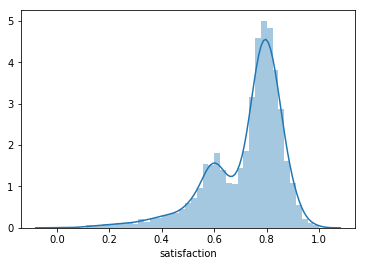

In [856]:
sns.distplot(full_similarity_Y)
plt.show()

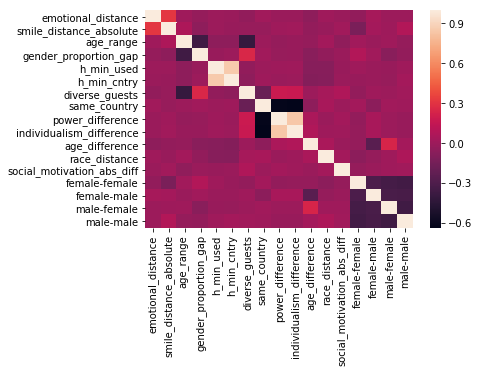

,emotional_distance,smile_distance_absolute,age_range,gender_proportion_gap,h_min_used,h_min_cntry,diverse_guests,same_country,power_difference,individualism_difference,age_difference,race_distance,social_motivation_abs_diff,female-female,female-male,male-female,male-male
emotional_distance,1,0.310238,0.0122022,-0.0287055,0.000730641,-0.00341655,-0.035782,0.0163505,-0.00630725,-0.00806706,-0.0500205,0.0108871,-0.00538709,-0.0386494,0.0393641,0.00144433,-0.000930347
smile_distance_absolute,0.310238,1,0.0636305,-0.0491527,-0.00217742,-0.0107961,-0.0168281,-0.0205456,0.0158579,0.0192889,-0.0300264,-0.0121697,0.0217976,-0.129004,0.0319735,0.00926163,0.0860396
age_range,0.0122022,0.0636305,1,-0.355023,-0.0508639,-0.0507287,-0.405359,-0.00244672,-0.0254722,-0.012562,-0.026465,0.0267334,-0.0437837,0.0181718,-0.00391274,0.0101935,-0.0239836
gender_proportion_gap,-0.0287055,-0.0491527,-0.355023,1,-0.0118262,-5.01276e-05,0.250056,0.0197669,-0.0196211,-0.0160042,-0.068518,-0.0404152,-0.00553528,0.0856168,0.021582,-0.0713323,-0.0332554
h_min_used,0.000730641,-0.00217742,-0.0508639,-0.0118262,1,0.856461,-0.0401776,0.00107558,0.00529705,0.0106609,-0.0783514,-0.07773,-0.0139932,0.0132581,-0.0092851,-0.0146209,0.0102433
h_min_cntry,-0.00341655,-0.0107961,-0.0507287,-5.01276e-05,0.856461,1,-0.0507556,0.00857474,-0.00465083,-0.00106621,-0.091951,-0.0838212,-0.0040571,-0.0115383,-0.00706914,-0.0167233,0.034296
diverse_guests,-0.035782,-0.0168281,-0.405359,0.250056,-0.0401776,-0.0507556,1,-0.191852,0.180057,0.173033,-0.00102157,0.0374396,0.0704608,-0.0325568,0.0107454,-4.50896e-05,0.0215396
same_country,0.0163505,-0.0205456,-0.00244672,0.0197669,0.00107558,0.00857474,-0.191852,1,-0.618458,-0.635949,-0.0495431,0.0465543,6.07947e-05,0.0232584,-0.0583935,0.0174595,0.0151784
power_difference,-0.00630725,0.0158579,-0.0254722,-0.0196211,0.00529705,-0.00465083,0.180057,-0.618458,1,0.842232,0.0596522,-0.00900273,0.0245009,-0.0299075,0.041959,0.000327928,-0.0107589
individualism_difference,-0.00806706,0.0192889,-0.012562,-0.0160042,0.0106609,-0.00106621,0.173033,-0.635949,0.842232,1,0.0763639,0.00438588,0.011675,-0.0268245,0.0444482,-0.00268164,-0.0131331


                          cols        vif
0           emotional_distance   1.112699
1      smile_distance_absolute   1.135300
2                    age_range   1.334551
3        gender_proportion_gap   1.191809
4                   h_min_used   3.773297
5                  h_min_cntry   3.792879
6               diverse_guests   1.303451
7                 same_country   1.786275
8             power_difference   3.597167
9     individualism_difference   3.733726
10              age_difference   1.137186
11               race_distance   1.025827
12  social_motivation_abs_diff   1.009304
13               female-female  13.615571
14                 female-male  11.590241
15                 male-female  15.261768
16                   male-male  15.115492
dropping 'male-female' at index: 15
                          cols        vif
0           emotional_distance   4.854800
1      smile_distance_absolute   2.130312
2                    age_range   5.957215
3        gender_proportion_gap   2.62281

In [851]:
analysis.test_features(full_similarity_X, full_similarity_Y, vif_thresh=10)

### Relative Satisfaction

In [798]:
full_similarity = full_set[["relative_satisfaction"]+all_feats]

In [799]:
full_similarity['gender_pairing'].value_counts()

female-female    1432
male-male        1398
male-female      1325
female-male      1243
Name: gender_pairing, dtype: int64

In [800]:
full_similarity = analysis.get_dummies(full_similarity, 'gender_pairing')

In [801]:
full_similarity_X,full_similarity_Y = get_x_y(full_similarity, 'relative_satisfaction')

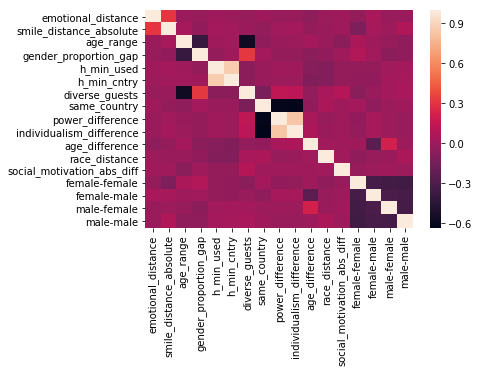

,emotional_distance,smile_distance_absolute,age_range,gender_proportion_gap,h_min_used,h_min_cntry,diverse_guests,same_country,power_difference,individualism_difference,age_difference,race_distance,social_motivation_abs_diff,female-female,female-male,male-female,male-male
emotional_distance,1,0.314781,-0.00546555,-0.0190975,0.0111117,0.00295968,-0.0175038,0.0105501,-0.00863092,-0.00834001,-0.0480687,0.00110826,0.00663866,-0.0327115,0.0490812,-0.00851653,-0.00583621
smile_distance_absolute,0.314781,1,0.0384128,-0.0360446,0.0255207,0.0179695,-0.00749008,-0.0295669,0.0222245,0.0254063,-0.0234727,-0.00725936,0.00997333,-0.111455,0.0387875,-0.000919422,0.0759487
age_range,-0.00546555,0.0384128,1,-0.390266,0.00770346,0.0210036,-0.56277,-0.0429951,-0.00581412,0.00480269,0.0251574,-0.005879,-0.0691281,0.0543312,0.00786038,-0.0185945,-0.0440409
gender_proportion_gap,-0.0190975,-0.0360446,-0.390266,1,-0.022743,0.00762133,0.321972,0.0283333,-0.0207682,-0.0227998,-0.057779,-0.0332076,0.0169677,0.0821179,0.0220759,-0.0646065,-0.0405037
h_min_used,0.0111117,0.0255207,0.00770346,-0.022743,1,0.860597,-0.0580517,-0.00644068,0.00767873,0.0110294,-0.0777247,-0.0904343,-0.0222829,-0.0222083,-0.0240919,0.0212968,0.0246124
h_min_cntry,0.00295968,0.0179695,0.0210036,0.00762133,0.860597,1,-0.0624884,-0.00426875,-0.001085,0.00232915,-0.0997481,-0.09615,-0.0246749,-0.0350127,-0.0341865,0.0267734,0.0418374
diverse_guests,-0.0175038,-0.00749008,-0.56277,0.321972,-0.0580517,-0.0624884,1,-0.119077,0.134862,0.125801,-0.0274164,0.0455147,0.0926732,-0.0654105,-0.00939027,0.028922,0.0465311
same_country,0.0105501,-0.0295669,-0.0429951,0.0283333,-0.00644068,-0.00426875,-0.119077,1,-0.619184,-0.6325,-0.0353258,0.0573212,0.0126567,0.0287759,-0.0446016,0.0044023,0.00953914
power_difference,-0.00863092,0.0222245,-0.00581412,-0.0207682,0.00767873,-0.001085,0.134862,-0.619184,1,0.834325,0.0482208,-0.0178698,0.0136884,-0.03438,0.0422339,0.00246348,-0.00836074
individualism_difference,-0.00834001,0.0254063,0.00480269,-0.0227998,0.0110294,0.00232915,0.125801,-0.6325,0.834325,1,0.0664826,-0.00572795,0.00860688,-0.0288201,0.0413095,0.00144743,-0.0120774


                          cols        vif
0           emotional_distance   1.115875
1      smile_distance_absolute   1.130701
2                    age_range   1.614746
3        gender_proportion_gap   1.239697
4                   h_min_used   3.887834
5                  h_min_cntry   3.923092
6               diverse_guests   1.576889
7                 same_country   1.778500
8             power_difference   3.459018
9     individualism_difference   3.560175
10              age_difference   1.113449
11               race_distance   1.023466
12  social_motivation_abs_diff   1.011209
13               female-female  14.872344
14                 female-male  12.103616
15                 male-female  14.576326
16                   male-male  14.434630
dropping 'female-female' at index: 13
                          cols        vif
0           emotional_distance   4.899671
1      smile_distance_absolute   2.142740
2                    age_range   6.619314
3        gender_proportion_gap   2.544

In [802]:
analysis.test_features(full_similarity_X, full_similarity_Y, vif_thresh=5)

# Shared

### Satisfaction

In [763]:
shared_similarity = shared_set[["satisfaction"]+all_feats]

shared_similarity['motivation_pairing'].value_counts()

shared_similarity = analysis.get_dummies(shared_similarity, 'motivation_pairing')

In [764]:
shared_similarity['gender_pairing'].value_counts()

female-female    1326
male-male         948
male-female       916
female-male       894
Name: gender_pairing, dtype: int64

In [765]:
shared_similarity = analysis.get_dummies(shared_similarity, 'gender_pairing')

In [766]:
shared_similarity_X,shared_similarity_Y = get_x_y(shared_similarity, 'satisfaction')

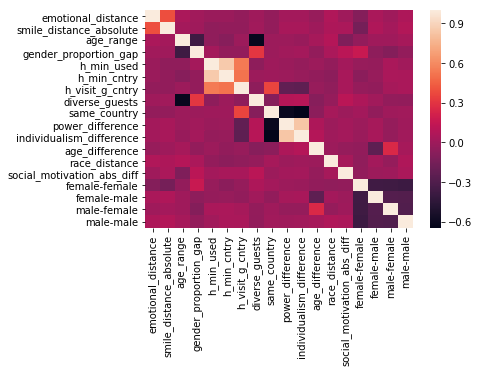

,emotional_distance,smile_distance_absolute,age_range,gender_proportion_gap,h_min_used,h_min_cntry,h_visit_g_cntry,diverse_guests,same_country,power_difference,individualism_difference,age_difference,race_distance,social_motivation_abs_diff,female-female,female-male,male-female,male-male
emotional_distance,1,0.395619,0.053903,0.0126517,-0.00898189,-0.0108953,-0.0352415,0.00444101,-0.0358009,0.0223221,0.0213158,-0.0268366,0.0725598,0.00582409,-0.0970186,0.045693,0.00440591,0.058499
smile_distance_absolute,0.395619,1,0.0291371,0.00764499,-0.0507406,-0.0441937,-0.0451301,0.011826,-0.0387168,0.0403316,0.0420344,0.00177994,0.061503,0.0539717,-0.152087,0.068093,0.0243922,0.077891
age_range,0.053903,0.0291371,1,-0.369358,-0.0502839,-0.0838571,-0.0024074,-0.616194,-0.00635809,-0.0023545,-0.0170212,0.0334509,0.082573,-0.113295,-0.0388839,0.00761553,0.00458026,0.0311426
gender_proportion_gap,0.0126517,0.00764499,-0.369358,1,0.0262765,-0.0349822,-0.0381561,0.311549,-0.00620654,0.0155371,0.0268937,-0.0356308,0.049812,0.107237,0.170677,-0.0574106,-0.0953105,-0.0389066
h_min_used,-0.00898189,-0.0507406,-0.0502839,0.0262765,1,0.854439,0.540421,-0.0549179,0.00411959,-0.0148124,-0.0330191,-0.00706976,-0.0381464,0.0195195,-0.0276388,-0.0306369,0.0457082,0.0155024
h_min_cntry,-0.0108953,-0.0441937,-0.0838571,-0.0349822,0.854439,1,0.51483,-0.00380879,-0.00212811,-0.00586315,-0.0255069,-0.0442543,-0.0659895,0.0377804,-0.0684169,-0.0227752,0.0503177,0.048476
h_visit_g_cntry,-0.0352415,-0.0451301,-0.0024074,-0.0381561,0.540421,0.51483,1,-0.0599857,0.363289,-0.227453,-0.245447,-0.024612,-0.0510964,0.038685,-0.0314767,-0.0461457,0.0359477,0.0445921
diverse_guests,0.00444101,0.011826,-0.616194,0.311549,-0.0549179,-0.00380879,-0.0599857,1,-0.0867879,0.0892798,0.097259,-0.0816396,-0.0320875,0.110673,0.0617579,0.0131106,-0.0382798,-0.0435179
same_country,-0.0358009,-0.0387168,-0.00635809,-0.00620654,0.00411959,-0.00212811,0.363289,-0.0867879,1,-0.600902,-0.64461,-0.0626566,0.0340781,-0.00787056,0.0202848,-0.0427665,0.00742033,0.0120573
power_difference,0.0223221,0.0403316,-0.0023545,0.0155371,-0.0148124,-0.00586315,-0.227453,0.0892798,-0.600902,1,0.837041,0.060276,-0.00242186,0.0178927,-0.00350532,0.0309272,-0.032035,0.00524684


                          cols        vif
0           emotional_distance   1.198753
1      smile_distance_absolute   1.214961
2                    age_range   1.781929
3        gender_proportion_gap   1.255638
4                   h_min_used   4.114016
5                  h_min_cntry   3.963388
6              h_visit_g_cntry   1.785740
7               diverse_guests   1.708571
8                 same_country   2.008186
9             power_difference   3.425327
10    individualism_difference   3.770906
11              age_difference   1.140697
12               race_distance   1.036872
13  social_motivation_abs_diff   1.034546
14               female-female  18.282353
15                 female-male  11.822475
16                 male-female  13.737556
17                   male-male  13.742782
dropping 'female-female' at index: 14
                          cols        vif
0           emotional_distance   5.059274
1      smile_distance_absolute   2.207629
2                    age_range   8.497

In [767]:
analysis.test_features(shared_similarity_X, shared_similarity_Y, vif_thresh=5)

### Relative Satisfaction

In [768]:
shared_similarity = shared_set[["relative_satisfaction"]+all_feats]

shared_similarity['motivation_pairing'].value_counts()

shared_similarity = analysis.get_dummies(shared_similarity, 'motivation_pairing')

In [769]:
shared_similarity['gender_pairing'].value_counts()

female-female    1326
male-male         948
male-female       916
female-male       894
Name: gender_pairing, dtype: int64

In [770]:
shared_similarity = analysis.get_dummies(shared_similarity, 'gender_pairing')

In [771]:
shared_similarity_X,shared_similarity_Y = get_x_y(shared_similarity, 'relative_satisfaction')

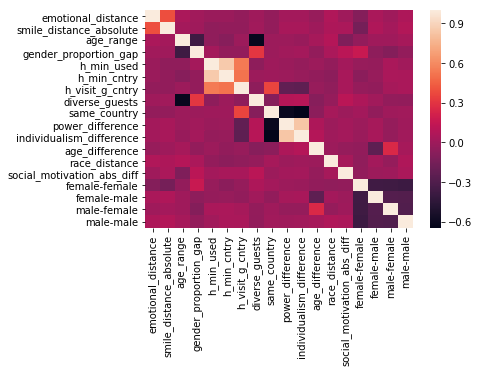

,emotional_distance,smile_distance_absolute,age_range,gender_proportion_gap,h_min_used,h_min_cntry,h_visit_g_cntry,diverse_guests,same_country,power_difference,individualism_difference,age_difference,race_distance,social_motivation_abs_diff,female-female,female-male,male-female,male-male
emotional_distance,1,0.395619,0.053903,0.0126517,-0.00898189,-0.0108953,-0.0352415,0.00444101,-0.0358009,0.0223221,0.0213158,-0.0268366,0.0725598,0.00582409,-0.0970186,0.045693,0.00440591,0.058499
smile_distance_absolute,0.395619,1,0.0291371,0.00764499,-0.0507406,-0.0441937,-0.0451301,0.011826,-0.0387168,0.0403316,0.0420344,0.00177994,0.061503,0.0539717,-0.152087,0.068093,0.0243922,0.077891
age_range,0.053903,0.0291371,1,-0.369358,-0.0502839,-0.0838571,-0.0024074,-0.616194,-0.00635809,-0.0023545,-0.0170212,0.0334509,0.082573,-0.113295,-0.0388839,0.00761553,0.00458026,0.0311426
gender_proportion_gap,0.0126517,0.00764499,-0.369358,1,0.0262765,-0.0349822,-0.0381561,0.311549,-0.00620654,0.0155371,0.0268937,-0.0356308,0.049812,0.107237,0.170677,-0.0574106,-0.0953105,-0.0389066
h_min_used,-0.00898189,-0.0507406,-0.0502839,0.0262765,1,0.854439,0.540421,-0.0549179,0.00411959,-0.0148124,-0.0330191,-0.00706976,-0.0381464,0.0195195,-0.0276388,-0.0306369,0.0457082,0.0155024
h_min_cntry,-0.0108953,-0.0441937,-0.0838571,-0.0349822,0.854439,1,0.51483,-0.00380879,-0.00212811,-0.00586315,-0.0255069,-0.0442543,-0.0659895,0.0377804,-0.0684169,-0.0227752,0.0503177,0.048476
h_visit_g_cntry,-0.0352415,-0.0451301,-0.0024074,-0.0381561,0.540421,0.51483,1,-0.0599857,0.363289,-0.227453,-0.245447,-0.024612,-0.0510964,0.038685,-0.0314767,-0.0461457,0.0359477,0.0445921
diverse_guests,0.00444101,0.011826,-0.616194,0.311549,-0.0549179,-0.00380879,-0.0599857,1,-0.0867879,0.0892798,0.097259,-0.0816396,-0.0320875,0.110673,0.0617579,0.0131106,-0.0382798,-0.0435179
same_country,-0.0358009,-0.0387168,-0.00635809,-0.00620654,0.00411959,-0.00212811,0.363289,-0.0867879,1,-0.600902,-0.64461,-0.0626566,0.0340781,-0.00787056,0.0202848,-0.0427665,0.00742033,0.0120573
power_difference,0.0223221,0.0403316,-0.0023545,0.0155371,-0.0148124,-0.00586315,-0.227453,0.0892798,-0.600902,1,0.837041,0.060276,-0.00242186,0.0178927,-0.00350532,0.0309272,-0.032035,0.00524684


                          cols        vif
0           emotional_distance   1.198753
1      smile_distance_absolute   1.214961
2                    age_range   1.781929
3        gender_proportion_gap   1.255638
4                   h_min_used   4.114016
5                  h_min_cntry   3.963388
6              h_visit_g_cntry   1.785740
7               diverse_guests   1.708571
8                 same_country   2.008186
9             power_difference   3.425327
10    individualism_difference   3.770906
11              age_difference   1.140697
12               race_distance   1.036872
13  social_motivation_abs_diff   1.034546
14               female-female  18.282353
15                 female-male  11.822475
16                 male-female  13.737556
17                   male-male  13.742782
dropping 'female-female' at index: 14
                          cols        vif
0           emotional_distance   5.059274
1      smile_distance_absolute   2.207629
2                    age_range   8.497

In [772]:
analysis.test_features(shared_similarity_X, shared_similarity_Y, vif_thresh=5)

# Profile Emotion

# Full

### Satisfaction

In [697]:
full_emotion = full_set[["satisfaction"]+demo_emotion]

In [698]:
full_emotion_X,full_emotion_Y = get_x_y(full_emotion, 'satisfaction')

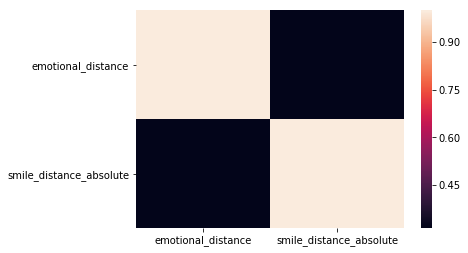

,emotional_distance,smile_distance_absolute
emotional_distance,1,0.314781
smile_distance_absolute,0.314781,1


                      cols       vif
0       emotional_distance  2.048959
1  smile_distance_absolute  2.048959
Remaining variables:
Index(['emotional_distance', 'smile_distance_absolute'], dtype='object')
                            OLS Regression Results                            
Dep. Variable:           satisfaction   R-squared:                       0.761
Model:                            OLS   Adj. R-squared:                  0.761
Method:                 Least Squares   F-statistic:                     8592.
Date:                Thu, 06 Sep 2018   Prob (F-statistic):               0.00
Time:                        10:45:02   Log-Likelihood:                -2136.5
No. Observations:                5398   AIC:                             4277.
Df Residuals:                    5396   BIC:                             4290.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
     

In [699]:
analysis.test_features(full_emotion_X, full_emotion_Y, vif_thresh=5)

### Relative Satisfaction

In [700]:
full_emotion = full_set[["relative_satisfaction"]+demo_emotion]

In [701]:
cntry_cult_X,cntry_cult_Y = get_x_y(full_emotion, 'relative_satisfaction')

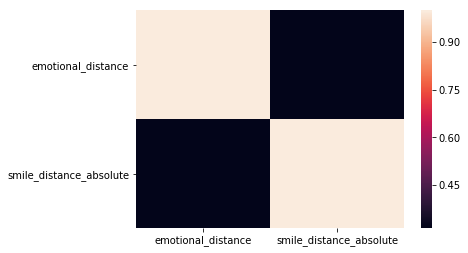

,emotional_distance,smile_distance_absolute
emotional_distance,1,0.314781
smile_distance_absolute,0.314781,1


                      cols       vif
0       emotional_distance  2.048959
1  smile_distance_absolute  2.048959
Remaining variables:
Index(['emotional_distance', 'smile_distance_absolute'], dtype='object')
                            OLS Regression Results                            
Dep. Variable:           satisfaction   R-squared:                       0.761
Model:                            OLS   Adj. R-squared:                  0.761
Method:                 Least Squares   F-statistic:                     8592.
Date:                Thu, 06 Sep 2018   Prob (F-statistic):               0.00
Time:                        10:45:21   Log-Likelihood:                -2136.5
No. Observations:                5398   AIC:                             4277.
Df Residuals:                    5396   BIC:                             4290.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
     

In [702]:
analysis.test_features(full_emotion_X, full_emotion_Y, vif_thresh=5)

# Shared

### Satisfaction

In [703]:
shared_emotion = shared_set[["satisfaction"]+demo_emotion]

In [704]:
shared_emotion_X,shared_emotion_Y = get_x_y(shared_emotion, 'satisfaction')

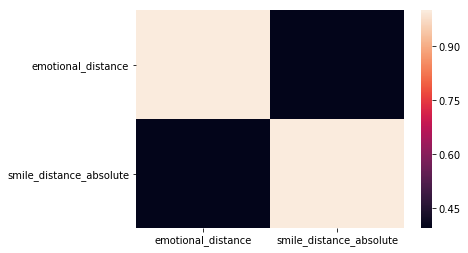

,emotional_distance,smile_distance_absolute
emotional_distance,1,0.395619
smile_distance_absolute,0.395619,1


                      cols       vif
0       emotional_distance  2.136825
1  smile_distance_absolute  2.136825
Remaining variables:
Index(['emotional_distance', 'smile_distance_absolute'], dtype='object')
                            OLS Regression Results                            
Dep. Variable:           satisfaction   R-squared:                       0.744
Model:                            OLS   Adj. R-squared:                  0.744
Method:                 Least Squares   F-statistic:                     5921.
Date:                Thu, 06 Sep 2018   Prob (F-statistic):               0.00
Time:                        10:45:26   Log-Likelihood:                -1717.6
No. Observations:                4084   AIC:                             3439.
Df Residuals:                    4082   BIC:                             3452.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
     

In [705]:
analysis.test_features(shared_emotion_X, shared_emotion_Y, vif_thresh=5)

### Relative Satisfaction

In [706]:
shared_emotion = shared_set[["relative_satisfaction"]+demo_emotion]

In [707]:
shared_emotion_X,shared_emotion_Y = get_x_y(shared_emotion, 'relative_satisfaction')

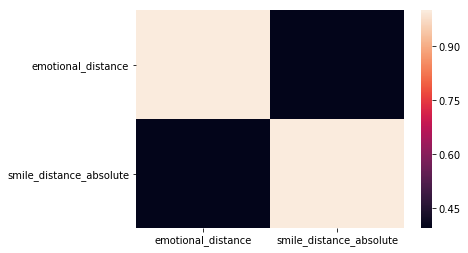

,emotional_distance,smile_distance_absolute
emotional_distance,1,0.395619
smile_distance_absolute,0.395619,1


                      cols       vif
0       emotional_distance  2.136825
1  smile_distance_absolute  2.136825
Remaining variables:
Index(['emotional_distance', 'smile_distance_absolute'], dtype='object')
                              OLS Regression Results                             
Dep. Variable:     relative_satisfaction   R-squared:                       0.743
Model:                               OLS   Adj. R-squared:                  0.743
Method:                    Least Squares   F-statistic:                     5900.
Date:                   Thu, 06 Sep 2018   Prob (F-statistic):               0.00
Time:                           10:45:34   Log-Likelihood:                -1593.9
No. Observations:                   4084   AIC:                             3192.
Df Residuals:                       4082   BIC:                             3204.
Df Model:                              2                                         
Covariance Type:               nonrobust                 

In [708]:
analysis.test_features(shared_emotion_X, shared_emotion_Y, vif_thresh=5)

# Explorer

# Full

### Satisfaction

In [709]:
full_explorer = full_set[["satisfaction"]+cntry_diversity+demo_diversity]

In [710]:
full_explorer_X,full_explorer_Y = get_x_y(full_explorer, 'satisfaction')

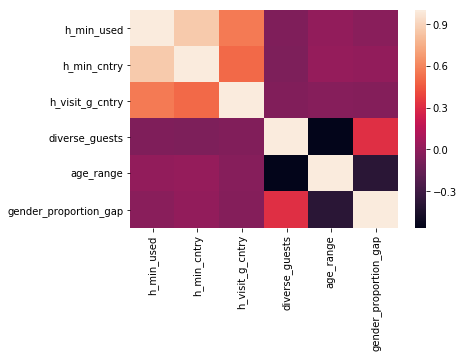

,h_min_used,h_min_cntry,h_visit_g_cntry,diverse_guests,age_range,gender_proportion_gap
h_min_used,1,0.860597,0.564094,-0.0580517,0.00770346,-0.022743
h_min_cntry,0.860597,1,0.506205,-0.0624884,0.0210036,0.00762133
h_visit_g_cntry,0.564094,0.506205,1,-0.0509333,-0.0376326,-0.0385937
diverse_guests,-0.0580517,-0.0624884,-0.0509333,1,-0.56277,0.321972
age_range,0.00770346,0.0210036,-0.0376326,-0.56277,1,-0.390266
gender_proportion_gap,-0.022743,0.00762133,-0.0385937,0.321972,-0.390266,1


                    cols       vif
0             h_min_used  5.552211
1            h_min_cntry  5.066435
2        h_visit_g_cntry  1.742300
3         diverse_guests  2.357423
4              age_range  1.838599
5  gender_proportion_gap  2.280845
dropping 'h_min_used' at index: 0
                    cols       vif
0            h_min_cntry  1.756722
1        h_visit_g_cntry  1.588734
2         diverse_guests  2.351564
3              age_range  1.830053
4  gender_proportion_gap  2.278576
Remaining variables:
Index(['h_min_cntry', 'h_visit_g_cntry', 'diverse_guests', 'age_range',
       'gender_proportion_gap'],
      dtype='object')
                            OLS Regression Results                            
Dep. Variable:           satisfaction   R-squared:                       0.911
Model:                            OLS   Adj. R-squared:                  0.911
Method:                 Least Squares   F-statistic:                 1.101e+04
Date:                Thu, 06 Sep 2018   Prob (F

In [711]:
analysis.test_features(full_explorer_X, full_explorer_Y, vif_thresh=5)

### Relative Satisfaction

In [675]:
full_explorer = full_set[["relative_satisfaction"]+cntry_diversity+demo_diversity]

In [676]:
cntry_cult_X,cntry_cult_Y = get_x_y(full_explorer, 'relative_satisfaction')

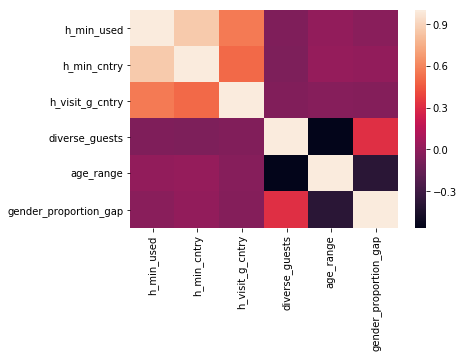

,h_min_used,h_min_cntry,h_visit_g_cntry,diverse_guests,age_range,gender_proportion_gap
h_min_used,1,0.860597,0.564094,-0.0580517,0.00770346,-0.022743
h_min_cntry,0.860597,1,0.506205,-0.0624884,0.0210036,0.00762133
h_visit_g_cntry,0.564094,0.506205,1,-0.0509333,-0.0376326,-0.0385937
diverse_guests,-0.0580517,-0.0624884,-0.0509333,1,-0.56277,0.321972
age_range,0.00770346,0.0210036,-0.0376326,-0.56277,1,-0.390266
gender_proportion_gap,-0.022743,0.00762133,-0.0385937,0.321972,-0.390266,1


                    cols       vif
0             h_min_used  5.552211
1            h_min_cntry  5.066435
2        h_visit_g_cntry  1.742300
3         diverse_guests  2.357423
4              age_range  1.838599
5  gender_proportion_gap  2.280845
dropping 'h_min_used' at index: 0
                    cols       vif
0            h_min_cntry  1.756722
1        h_visit_g_cntry  1.588734
2         diverse_guests  2.351564
3              age_range  1.830053
4  gender_proportion_gap  2.278576
Remaining variables:
Index(['h_min_cntry', 'h_visit_g_cntry', 'diverse_guests', 'age_range',
       'gender_proportion_gap'],
      dtype='object')
                            OLS Regression Results                            
Dep. Variable:           satisfaction   R-squared:                       0.911
Model:                            OLS   Adj. R-squared:                  0.911
Method:                 Least Squares   F-statistic:                 1.101e+04
Date:                Thu, 06 Sep 2018   Prob (F

In [677]:
analysis.test_features(full_explorer_X, full_explorer_Y, vif_thresh=5)

# Shared

### Satisfaction

In [678]:
shared_explorer = shared_set[["satisfaction"]+cntry_diversity+demo_diversity]

In [679]:
shared_explorer_X,shared_explorer_Y = get_x_y(shared_explorer, 'satisfaction')

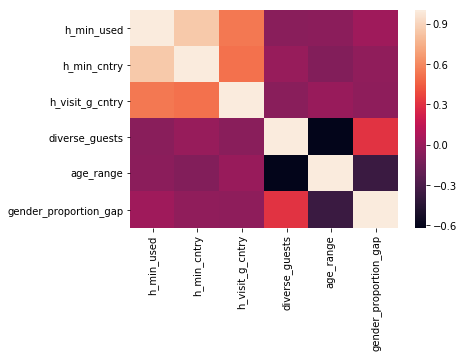

,h_min_used,h_min_cntry,h_visit_g_cntry,diverse_guests,age_range,gender_proportion_gap
h_min_used,1,0.854439,0.540421,-0.0549179,-0.0502839,0.0262765
h_min_cntry,0.854439,1,0.51483,-0.00380879,-0.0838571,-0.0349822
h_visit_g_cntry,0.540421,0.51483,1,-0.0599857,-0.0024074,-0.0381561
diverse_guests,-0.0549179,-0.00380879,-0.0599857,1,-0.616194,0.311549
age_range,-0.0502839,-0.0838571,-0.0024074,-0.616194,1,-0.369358
gender_proportion_gap,0.0262765,-0.0349822,-0.0381561,0.311549,-0.369358,1


                    cols       vif
0             h_min_used  5.415404
1            h_min_cntry  5.275919
2        h_visit_g_cntry  1.716903
3         diverse_guests  2.236176
4              age_range  1.946890
5  gender_proportion_gap  2.404246
dropping 'h_min_used' at index: 0
                    cols       vif
0            h_min_cntry  1.830680
1        h_visit_g_cntry  1.631005
2         diverse_guests  2.197130
3              age_range  1.943857
4  gender_proportion_gap  2.340026
Remaining variables:
Index(['h_min_cntry', 'h_visit_g_cntry', 'diverse_guests', 'age_range',
       'gender_proportion_gap'],
      dtype='object')
                            OLS Regression Results                            
Dep. Variable:           satisfaction   R-squared:                       0.932
Model:                            OLS   Adj. R-squared:                  0.932
Method:                 Least Squares   F-statistic:                 1.121e+04
Date:                Thu, 06 Sep 2018   Prob (F

In [680]:
analysis.test_features(shared_explorer_X, shared_explorer_Y, vif_thresh=5)

### Relative Satisfaction

In [681]:
shared_explorer = shared_set[["relative_satisfaction"]+cntry_diversity+demo_diversity]

In [682]:
shared_explorer_X,shared_explorer_Y = get_x_y(shared_explorer, 'relative_satisfaction')

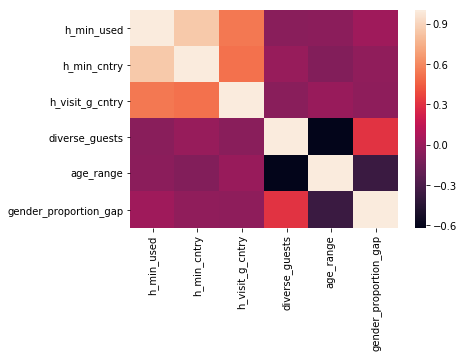

,h_min_used,h_min_cntry,h_visit_g_cntry,diverse_guests,age_range,gender_proportion_gap
h_min_used,1,0.854439,0.540421,-0.0549179,-0.0502839,0.0262765
h_min_cntry,0.854439,1,0.51483,-0.00380879,-0.0838571,-0.0349822
h_visit_g_cntry,0.540421,0.51483,1,-0.0599857,-0.0024074,-0.0381561
diverse_guests,-0.0549179,-0.00380879,-0.0599857,1,-0.616194,0.311549
age_range,-0.0502839,-0.0838571,-0.0024074,-0.616194,1,-0.369358
gender_proportion_gap,0.0262765,-0.0349822,-0.0381561,0.311549,-0.369358,1


                    cols       vif
0             h_min_used  5.415404
1            h_min_cntry  5.275919
2        h_visit_g_cntry  1.716903
3         diverse_guests  2.236176
4              age_range  1.946890
5  gender_proportion_gap  2.404246
dropping 'h_min_used' at index: 0
                    cols       vif
0            h_min_cntry  1.830680
1        h_visit_g_cntry  1.631005
2         diverse_guests  2.197130
3              age_range  1.943857
4  gender_proportion_gap  2.340026
Remaining variables:
Index(['h_min_cntry', 'h_visit_g_cntry', 'diverse_guests', 'age_range',
       'gender_proportion_gap'],
      dtype='object')
                              OLS Regression Results                             
Dep. Variable:     relative_satisfaction   R-squared:                       0.930
Model:                               OLS   Adj. R-squared:                  0.930
Method:                    Least Squares   F-statistic:                 1.080e+04
Date:                   Thu, 06 Sep

In [683]:
analysis.test_features(shared_explorer_X, shared_explorer_Y, vif_thresh=5)

# Motivation

# Full

### Satisfaction

In [641]:
full_mot= full_set[["satisfaction"]+airbnb_feats]

In [642]:
full_mot['motivation_pairing'].value_counts()

bus-soc    2400
soc-bus    2217
no-diff     781
Name: motivation_pairing, dtype: int64

In [643]:
full_mot = analysis.get_dummies(full_mot, 'motivation_pairing')

In [644]:
full_mot_X,full_mot_Y = get_x_y(full_mot, 'satisfaction')

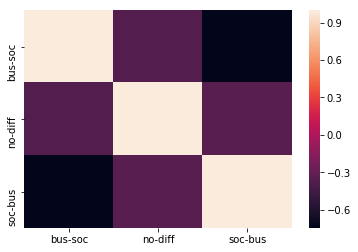

,bus-soc,no-diff,soc-bus
bus-soc,1,-0.367989,-0.746949
no-diff,-0.367989,1,-0.343358
soc-bus,-0.746949,-0.343358,1


      cols  vif
0  bus-soc  1.0
1  no-diff  1.0
2  soc-bus  1.0
Remaining variables:
Index(['bus-soc', 'no-diff', 'soc-bus'], dtype='object')
                            OLS Regression Results                            
Dep. Variable:           satisfaction   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     4.486
Date:                Thu, 06 Sep 2018   Prob (F-statistic):             0.0113
Time:                        10:30:34   Log-Likelihood:                 2846.6
No. Observations:                5398   AIC:                            -5687.
Df Residuals:                    5395   BIC:                            -5667.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025  

In [645]:
analysis.test_features(full_mot_X, full_mot_Y, vif_thresh=5)

### Relative Satisfaction

In [647]:
full_mot = full_set[["relative_satisfaction"]+airbnb_feats]

In [649]:
full_mot['motivation_pairing'].value_counts()

bus-soc    2400
soc-bus    2217
no-diff     781
Name: motivation_pairing, dtype: int64

In [650]:
full_mot = analysis.get_dummies(full_mot, 'motivation_pairing')

In [651]:
airbnb_feat_X,airbnb_feat_Y = get_x_y(full_mot, 'relative_satisfaction')

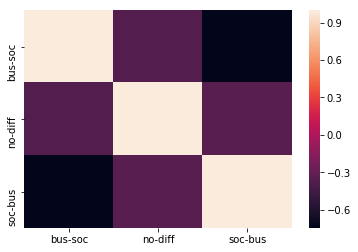

,bus-soc,no-diff,soc-bus
bus-soc,1,-0.367989,-0.746949
no-diff,-0.367989,1,-0.343358
soc-bus,-0.746949,-0.343358,1


      cols  vif
0  bus-soc  1.0
1  no-diff  1.0
2  soc-bus  1.0
Remaining variables:
Index(['bus-soc', 'no-diff', 'soc-bus'], dtype='object')
                            OLS Regression Results                            
Dep. Variable:           satisfaction   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     4.486
Date:                Thu, 06 Sep 2018   Prob (F-statistic):             0.0113
Time:                        10:31:28   Log-Likelihood:                 2846.6
No. Observations:                5398   AIC:                            -5687.
Df Residuals:                    5395   BIC:                            -5667.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025  

In [652]:
analysis.test_features(full_mot_X, full_mot_Y, vif_thresh=5)

# Shared

### Satisfaction

In [656]:
shared_mot = shared_set[["satisfaction"]+airbnb_feats]

In [657]:
shared_mot['motivation_pairing'].value_counts()

soc-bus    1979
bus-soc    1784
no-diff     321
Name: motivation_pairing, dtype: int64

In [658]:
shared_mot = analysis.get_dummies(shared_mot, 'motivation_pairing')

In [659]:
shared_mot_X,shared_mot_Y = get_x_y(shared_mot, 'satisfaction')

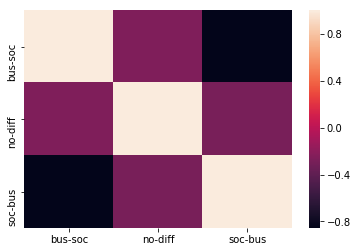

,bus-soc,no-diff,soc-bus
bus-soc,1,-0.257228,-0.853946
no-diff,-0.257228,1,-0.283193
soc-bus,-0.853946,-0.283193,1


      cols  vif
0  bus-soc  1.0
1  no-diff  1.0
2  soc-bus  1.0
Remaining variables:
Index(['bus-soc', 'no-diff', 'soc-bus'], dtype='object')
                            OLS Regression Results                            
Dep. Variable:           satisfaction   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     4.009
Date:                Thu, 06 Sep 2018   Prob (F-statistic):             0.0182
Time:                        10:32:02   Log-Likelihood:                 2412.4
No. Observations:                4084   AIC:                            -4819.
Df Residuals:                    4081   BIC:                            -4800.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025  

In [660]:
analysis.test_features(shared_mot_X, shared_mot_Y, vif_thresh=5)

### Relative Satisfaction

In [661]:
shared_mot = shared_set[["relative_satisfaction"]+airbnb_feats]

In [662]:
shared_mot['motivation_pairing'].value_counts()

soc-bus    1979
bus-soc    1784
no-diff     321
Name: motivation_pairing, dtype: int64

In [663]:
shared_mot = analysis.get_dummies(shared_mot, 'motivation_pairing')

In [664]:
shared_mot_X,shared_mot_Y = get_x_y(shared_mot, 'relative_satisfaction')

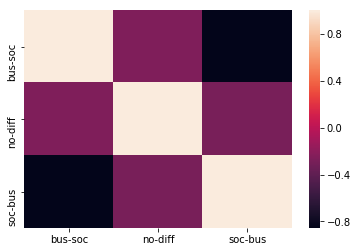

,bus-soc,no-diff,soc-bus
bus-soc,1,-0.257228,-0.853946
no-diff,-0.257228,1,-0.283193
soc-bus,-0.853946,-0.283193,1


      cols  vif
0  bus-soc  1.0
1  no-diff  1.0
2  soc-bus  1.0
Remaining variables:
Index(['bus-soc', 'no-diff', 'soc-bus'], dtype='object')
                              OLS Regression Results                             
Dep. Variable:     relative_satisfaction   R-squared:                       0.001
Model:                               OLS   Adj. R-squared:                  0.001
Method:                    Least Squares   F-statistic:                     2.173
Date:                   Thu, 06 Sep 2018   Prob (F-statistic):              0.114
Time:                           10:32:49   Log-Likelihood:                 2472.8
No. Observations:                   4084   AIC:                            -4940.
Df Residuals:                       4081   BIC:                            -4921.
Df Model:                              2                                         
Covariance Type:               nonrobust                                         
                 coef    std err      

In [665]:
analysis.test_features(shared_mot_X, shared_mot_Y, vif_thresh=5)

# Country_culture

# Full

### Satisfaction

In [666]:
full_cntry = full_set[["satisfaction"]+cntry_cult]

In [600]:
full_cntry_X,full_cntry_Y = get_x_y(full_cntry, 'satisfaction')

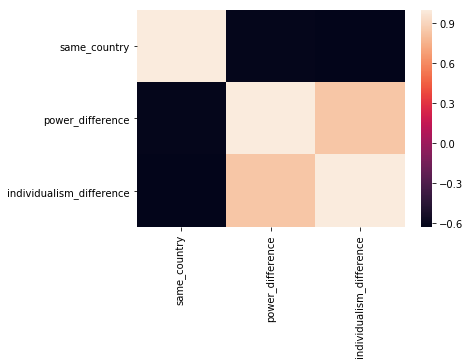

,same_country,power_difference,individualism_difference
same_country,1,-0.619184,-0.6325
power_difference,-0.619184,1,0.834325
individualism_difference,-0.6325,0.834325,1


                       cols     vif
0              same_country  1.0000
1          power_difference  4.0652
2  individualism_difference  4.0652
Remaining variables:
Index(['same_country', 'power_difference', 'individualism_difference'], dtype='object')
                            OLS Regression Results                            
Dep. Variable:           satisfaction   R-squared:                       0.786
Model:                            OLS   Adj. R-squared:                  0.786
Method:                 Least Squares   F-statistic:                     6623.
Date:                Thu, 06 Sep 2018   Prob (F-statistic):               0.00
Time:                        10:15:17   Log-Likelihood:                -1833.0
No. Observations:                5398   AIC:                             3672.
Df Residuals:                    5395   BIC:                             3692.
Df Model:                           3                                         
Covariance Type:            nonrobus

In [601]:
analysis.test_features(full_cntry_X, full_cntry_Y, vif_thresh=5)

### Relative Satisfaction

In [602]:
full_cntry = full_set[["relative_satisfaction"]+cntry_cult]

In [603]:
cntry_cult_X,cntry_cult_Y = get_x_y(full_cntry, 'relative_satisfaction')

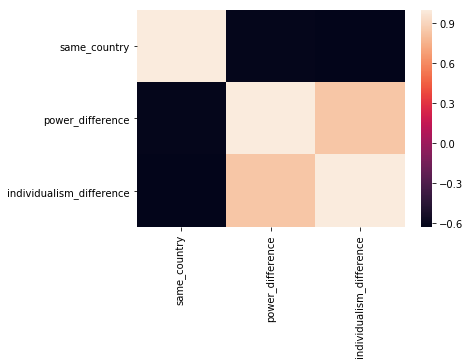

,same_country,power_difference,individualism_difference
same_country,1,-0.619184,-0.6325
power_difference,-0.619184,1,0.834325
individualism_difference,-0.6325,0.834325,1


                       cols     vif
0              same_country  1.0000
1          power_difference  4.0652
2  individualism_difference  4.0652
Remaining variables:
Index(['same_country', 'power_difference', 'individualism_difference'], dtype='object')
                            OLS Regression Results                            
Dep. Variable:           satisfaction   R-squared:                       0.786
Model:                            OLS   Adj. R-squared:                  0.786
Method:                 Least Squares   F-statistic:                     6623.
Date:                Thu, 06 Sep 2018   Prob (F-statistic):               0.00
Time:                        10:15:51   Log-Likelihood:                -1833.0
No. Observations:                5398   AIC:                             3672.
Df Residuals:                    5395   BIC:                             3692.
Df Model:                           3                                         
Covariance Type:            nonrobus

In [604]:
analysis.test_features(full_cntry_X, full_cntry_Y, vif_thresh=5)

# Shared

### Satisfaction

In [605]:
shared_cntry = shared_set[["satisfaction"]+cntry_cult]

In [606]:
shared_cntry_X,shared_cntry_Y = get_x_y(shared_cntry, 'satisfaction')

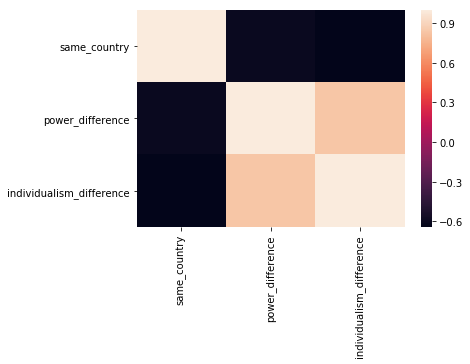

,same_country,power_difference,individualism_difference
same_country,1,-0.600902,-0.64461
power_difference,-0.600902,1,0.837041
individualism_difference,-0.64461,0.837041,1


                       cols       vif
0              same_country  1.000000
1          power_difference  4.378019
2  individualism_difference  4.378019
Remaining variables:
Index(['same_country', 'power_difference', 'individualism_difference'], dtype='object')
                            OLS Regression Results                            
Dep. Variable:           satisfaction   R-squared:                       0.773
Model:                            OLS   Adj. R-squared:                  0.773
Method:                 Least Squares   F-statistic:                     4643.
Date:                Thu, 06 Sep 2018   Prob (F-statistic):               0.00
Time:                        10:17:29   Log-Likelihood:                -1465.8
No. Observations:                4084   AIC:                             2938.
Df Residuals:                    4081   BIC:                             2957.
Df Model:                           3                                         
Covariance Type:            

In [607]:
analysis.test_features(shared_cntry_X, shared_cntry_Y, vif_thresh=5)

### Relative Satisfaction

In [608]:
shared_cntry = shared_set[["relative_satisfaction"]+cntry_cult]

In [609]:
shared_cntry_X,shared_cntry_Y = get_x_y(shared_cntry, 'relative_satisfaction')

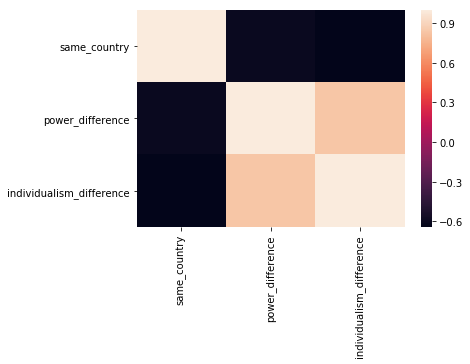

,same_country,power_difference,individualism_difference
same_country,1,-0.600902,-0.64461
power_difference,-0.600902,1,0.837041
individualism_difference,-0.64461,0.837041,1


                       cols       vif
0              same_country  1.000000
1          power_difference  4.378019
2  individualism_difference  4.378019
Remaining variables:
Index(['same_country', 'power_difference', 'individualism_difference'], dtype='object')
                              OLS Regression Results                             
Dep. Variable:     relative_satisfaction   R-squared:                       0.775
Model:                               OLS   Adj. R-squared:                  0.775
Method:                    Least Squares   F-statistic:                     4684.
Date:                   Thu, 06 Sep 2018   Prob (F-statistic):               0.00
Time:                           10:17:32   Log-Likelihood:                -1322.8
No. Observations:                   4084   AIC:                             2652.
Df Residuals:                       4081   BIC:                             2671.
Df Model:                              3                                         
C

In [610]:
analysis.test_features(shared_cntry_X, shared_cntry_Y, vif_thresh=5)

# Demographics

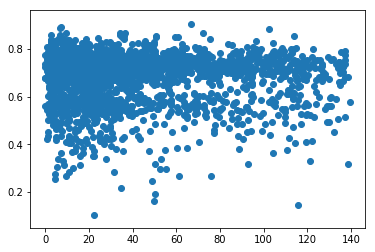

In [875]:
plt.scatter(shared_demo['race_distance'], shared_demo['satisfaction'])
plt.show()

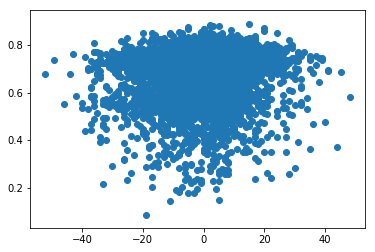

In [871]:
plt.scatter(full_demo['age_difference'], full_demo['satisfaction'])
plt.show()

# Full

### Satisfaction

In [867]:
full_demo = full_set[["satisfaction"]+demo_feats]

In [536]:
full_demo['gender_pairing'].value_counts()

female-female    1432
male-male        1398
male-female      1325
female-male      1243
Name: gender_pairing, dtype: int64

In [537]:
full_demo = analysis.get_dummies(full_demo, 'gender_pairing')

full_demo['age-pairing'].value_counts()

full_demo = analysis.get_dummies(full_demo, 'age-pairing')

In [538]:
full_demo_X,full_demo_Y = get_x_y(full_demo, 'satisfaction')

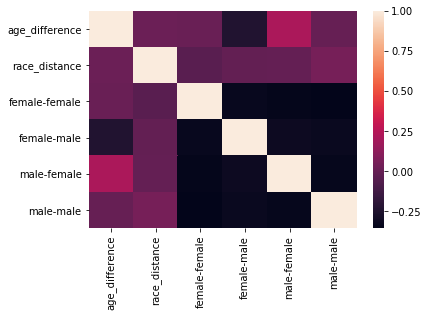

,age_difference,race_distance,female-female,female-male,male-female,male-male
age_difference,1,0.019297,0.0107637,-0.23713,0.217227,0.00364138
race_distance,0.019297,1,-0.0409957,-0.00829049,-0.00384172,0.053056
female-female,0.0107637,-0.0409957,1,-0.328659,-0.342725,-0.355237
female-male,-0.23713,-0.00829049,-0.328659,1,-0.311961,-0.323351
male-female,0.217227,-0.00384172,-0.342725,-0.311961,1,-0.33719
male-male,0.00364138,0.053056,-0.355237,-0.323351,-0.33719,1


             cols       vif
0  age_difference  1.086165
1   race_distance  1.003774
2   female-female  6.047947
3     female-male  4.545887
4     male-female  6.520757
5       male-male  5.993452
dropping 'male-female' at index: 4
             cols       vif
0  age_difference  3.895934
1   race_distance  2.319586
2   female-female  1.774407
3     female-male  1.551919
4       male-male  1.773844
Remaining variables:
Index(['age_difference', 'race_distance', 'female-female', 'female-male',
       'male-male'],
      dtype='object')
                            OLS Regression Results                            
Dep. Variable:           satisfaction   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.930
Method:                 Least Squares   F-statistic:                 1.424e+04
Date:                Thu, 06 Sep 2018   Prob (F-statistic):               0.00
Time:                        10:02:47   Log-Likelihood:             

In [539]:
analysis.test_features(full_demo_X, full_demo_Y, vif_thresh=5)

### Relative Satisfaction

In [540]:
full_demo = full_set[["relative_satisfaction"]+demo_feats]

In [541]:
full_demo['gender_pairing'].value_counts()

female-female    1432
male-male        1398
male-female      1325
female-male      1243
Name: gender_pairing, dtype: int64

In [542]:
full_demo = analysis.get_dummies(full_demo, 'gender_pairing')

In [543]:
full_demo_X,full_demo_Y = get_x_y(full_demo, 'relative_satisfaction')

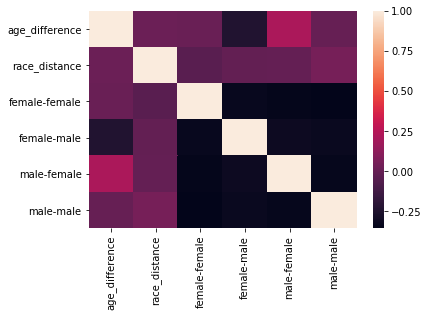

,age_difference,race_distance,female-female,female-male,male-female,male-male
age_difference,1,0.019297,0.0107637,-0.23713,0.217227,0.00364138
race_distance,0.019297,1,-0.0409957,-0.00829049,-0.00384172,0.053056
female-female,0.0107637,-0.0409957,1,-0.328659,-0.342725,-0.355237
female-male,-0.23713,-0.00829049,-0.328659,1,-0.311961,-0.323351
male-female,0.217227,-0.00384172,-0.342725,-0.311961,1,-0.33719
male-male,0.00364138,0.053056,-0.355237,-0.323351,-0.33719,1


             cols       vif
0  age_difference  1.086165
1   race_distance  1.003774
2   female-female  6.047947
3     female-male  4.545887
4     male-female  6.520757
5       male-male  5.993452
dropping 'male-female' at index: 4
             cols       vif
0  age_difference  3.895934
1   race_distance  2.319586
2   female-female  1.774407
3     female-male  1.551919
4       male-male  1.773844
Remaining variables:
Index(['age_difference', 'race_distance', 'female-female', 'female-male',
       'male-male'],
      dtype='object')
                              OLS Regression Results                             
Dep. Variable:     relative_satisfaction   R-squared:                       0.930
Model:                               OLS   Adj. R-squared:                  0.930
Method:                    Least Squares   F-statistic:                 1.426e+04
Date:                   Thu, 06 Sep 2018   Prob (F-statistic):               0.00
Time:                           10:03:23   Log-Likeli

In [544]:
analysis.test_features(full_demo_X, full_demo_Y, vif_thresh=5)

# Shared

### Satisfaction

In [873]:
shared_demo = shared_set[["satisfaction"]+demo_feats]

In [874]:
shared_demo['gender_pairing'].value_counts()

female-female    776
male-female      496
female-male      482
male-male        472
Name: gender_pairing, dtype: int64

In [547]:
shared_demo = analysis.get_dummies(shared_demo, 'gender_pairing')

In [548]:
shared_demo_X,shared_demo_Y = get_x_y(shared_demo, 'satisfaction')

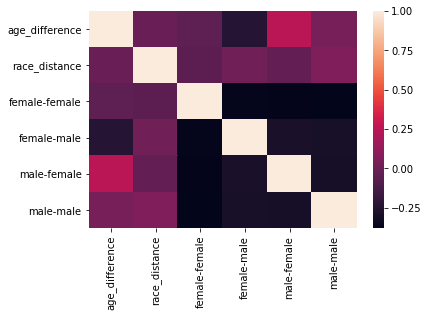

,age_difference,race_distance,female-female,female-male,male-female,male-male
age_difference,1,-0.00555891,-0.0441747,-0.24321,0.254003,0.0362518
race_distance,-0.00555891,1,-0.050596,0.0211858,-0.0303376,0.0653399
female-female,-0.0441747,-0.050596,1,-0.367069,-0.372846,-0.381233
female-male,-0.24321,0.0211858,-0.367069,1,-0.284661,-0.291065
male-female,0.254003,-0.0303376,-0.372846,-0.284661,1,-0.295646
male-male,0.0362518,0.0653399,-0.381233,-0.291065,-0.295646,1


             cols       vif
0  age_difference  1.109358
1   race_distance  1.006110
2   female-female  6.112496
3     female-male  3.850248
4     male-female  5.574614
5       male-male  5.010166
dropping 'female-female' at index: 2
             cols       vif
0  age_difference  3.736953
1   race_distance  2.302710
2     female-male  1.475821
3     male-female  1.752397
4       male-male  1.660157
Remaining variables:
Index(['age_difference', 'race_distance', 'female-male', 'male-female',
       'male-male'],
      dtype='object')
                            OLS Regression Results                            
Dep. Variable:           satisfaction   R-squared:                       0.919
Model:                            OLS   Adj. R-squared:                  0.919
Method:                 Least Squares   F-statistic:                     9254.
Date:                Thu, 06 Sep 2018   Prob (F-statistic):               0.00
Time:                        10:03:54   Log-Likelihood:             

In [549]:
analysis.test_features(shared_demo_X, shared_demo_Y, vif_thresh=5)

### Relative Satisfaction

In [550]:
shared_demo = shared_set[["relative_satisfaction"]+demo_feats]

In [551]:
shared_demo['gender_pairing'].value_counts()

female-female    1326
male-male         948
male-female       916
female-male       894
Name: gender_pairing, dtype: int64

In [552]:
shared_demo = analysis.get_dummies(shared_demo, 'gender_pairing')

In [553]:
shared_demo_X,shared_demo_Y = get_x_y(shared_demo, 'relative_satisfaction')

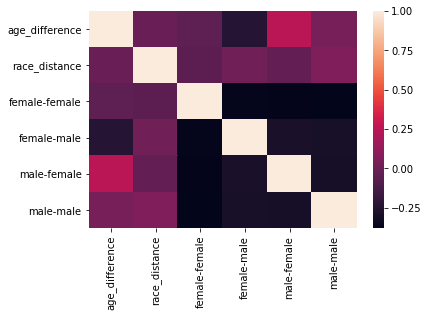

,age_difference,race_distance,female-female,female-male,male-female,male-male
age_difference,1,-0.00555891,-0.0441747,-0.24321,0.254003,0.0362518
race_distance,-0.00555891,1,-0.050596,0.0211858,-0.0303376,0.0653399
female-female,-0.0441747,-0.050596,1,-0.367069,-0.372846,-0.381233
female-male,-0.24321,0.0211858,-0.367069,1,-0.284661,-0.291065
male-female,0.254003,-0.0303376,-0.372846,-0.284661,1,-0.295646
male-male,0.0362518,0.0653399,-0.381233,-0.291065,-0.295646,1


             cols       vif
0  age_difference  1.109358
1   race_distance  1.006110
2   female-female  6.112496
3     female-male  3.850248
4     male-female  5.574614
5       male-male  5.010166
dropping 'female-female' at index: 2
             cols       vif
0  age_difference  3.736953
1   race_distance  2.302710
2     female-male  1.475821
3     male-female  1.752397
4       male-male  1.660157
Remaining variables:
Index(['age_difference', 'race_distance', 'female-male', 'male-female',
       'male-male'],
      dtype='object')
                              OLS Regression Results                             
Dep. Variable:     relative_satisfaction   R-squared:                       0.918
Model:                               OLS   Adj. R-squared:                  0.918
Method:                    Least Squares   F-statistic:                     9150.
Date:                   Thu, 06 Sep 2018   Prob (F-statistic):               0.00
Time:                           10:05:12   Log-Likeli

In [554]:
analysis.test_features(shared_demo_X, shared_demo_Y, vif_thresh=5)

In [864]:
from pygam import LogisticGAM
gam = LogisticGAM().fit(full_emotion_X, full_emotion_Y)


/Users/lynraybarends/anaconda3/lib/python3.6/site-packages/pygam/pygam.py:1522: RuntimeWarning: invalid value encountered in double_scalars
  r2['McFadden'] = full_ll/null_ll
/Users/lynraybarends/anaconda3/lib/python3.6/site-packages/pygam/pygam.py:1523: RuntimeWarning: invalid value encountered in double_scalars
  r2['McFadden_adj'] = 1. - (full_ll - self.statistics_['edof'])/null_ll


In [865]:
gam.summary()

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     31.8998
Link Function:                        LogitLink Log Likelihood:                                       -inf
Number of Samples:                         5398 AIC:                                                   inf
                                                AICc:                                                  inf
                                                UBRE:                                               2.1148
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.0069
Feature Function   Data Type      Num